In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [7]:
#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

In [11]:
#set up Colour style
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

TypeError: unhashable type: '_ColorPalette'

In [10]:
#Add CSV File
df = pd.read_csv("C:/Users/ACER/Desktop/Ayo programs/tm/creditcard.csv") #Make sure the CSV file is located in the same folder with this Code!
df.head(n=5) #just to check you imported the dataset properly

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#This section is used to confirm the data imported
df.shape #secondary check on the size of the dataframe


In [ ]:
#check to see if any values are null, which there are not
df.isnull().values.any() #THe output should be False

In [ ]:
#This section will give the output for Normal and Fraudulent rows of Data
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

In [ ]:
#Balance of Data Visualization
#Visual confirmation of unbalanced Data in the Dataset
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");


In [ ]:
#Summary Statistics of the Transaction Amount Data
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

In [ ]:
#Description of Differences btw the Normal and Fraud data
normal_df.Amount.describe() #For Normal
fraud_df.Amount.describe() #For Fraud

In [ ]:
#Visual Exploration of the Transaction Amount Data
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

In [ ]:
#Visual Exploration of the Data by Hour
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

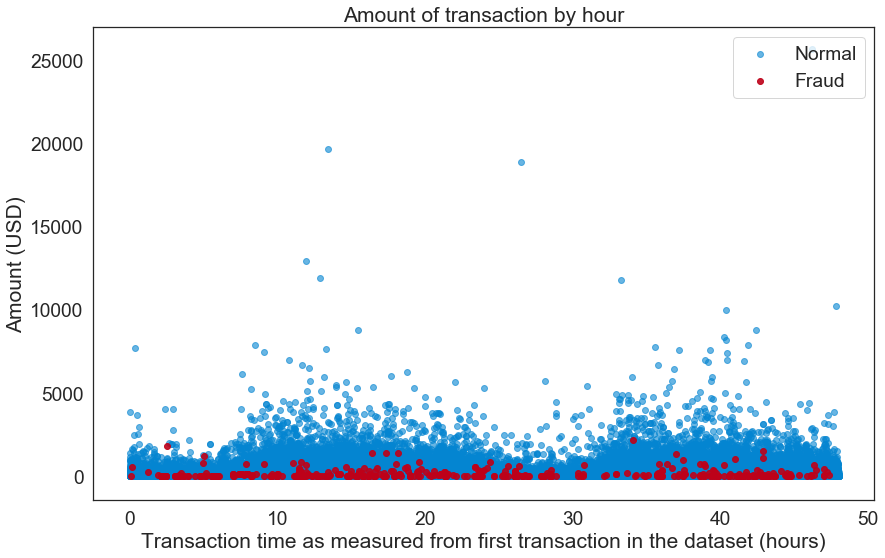

In [14]:
#Visual Exploration of Transaction Amount vs. Hour
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [15]:
#Model Setup: Basic Autoencoder

#Normalize and Scale Data
data = df.drop(['Time'], axis=1) #if you think the var is unimportant
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [16]:
#Dividing Training and 2Test Set
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column

In [17]:
# TEST
test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

In [18]:
# TRAIN 
train_x = train_x.values #transform to ndarray
test_x = test_x.values


In [19]:
#confirming the new ndarray is the expected shape
train_x.shape


(227468, 30)

In [20]:
#Creating the Model
#Autoencoder Layer Structure and Parameters
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [12]:
#Model Training and Logging
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

NameError: name 'autoencoder' is not defined

In [22]:
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

In [23]:
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [24]:
history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history


Train on 227468 samples, validate on 56962 samples


Epoch 1/100
227468/227468 [==============================] - 6s 27us/step - loss: 0.8643 - accuracy: 0.4963 - val_loss: 0.8275 - val_accuracy: 0.5800

Epoch 2/100
227468/227468 [==============================] - 4s 20us/step - loss: 0.7724 - accuracy: 0.6113 - val_loss: 0.7900 - val_accuracy: 0.6374
Epoch 3/100
227468/227468 [==============================] - 5s 23us/step - loss: 0.7473 - accuracy: 0.6550 - val_loss: 0.7736 - val_accuracy: 0.6627
Epoch 4/100
227468/227468 [==============================] - 5s 22us/step - loss: 0.7352 - accuracy: 0.6664 - val_loss: 0.7638 - val_accuracy: 0.6738
Epoch 5/100
227468/227468 [==============================] - 5s 21us/step - loss: 0.7285 - accuracy: 0.6726 - val_loss: 0.7597 - val_accuracy: 0.6784
Epoch 6/100
227468/227468 [==============================] - 5s 21us/step - loss: 0.7243 - accuracy: 0.6793 - val_loss: 0.7554 - val_accuracy: 0.6853
Epoch 7/100
227468/227468 [==================

Epoch 50/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7010 - accuracy: 0.7167 - val_loss: 0.7379 - val_accuracy: 0.7156
Epoch 51/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7007 - accuracy: 0.7148 - val_loss: 0.7343 - val_accuracy: 0.7205
Epoch 52/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7008 - accuracy: 0.7144 - val_loss: 0.7339 - val_accuracy: 0.7165
Epoch 53/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7004 - accuracy: 0.7130 - val_loss: 0.7336 - val_accuracy: 0.7218
Epoch 54/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7005 - accuracy: 0.7144 - val_loss: 0.7337 - val_accuracy: 0.7163
Epoch 55/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7001 - accuracy: 0.7143 - val_loss: 0.7346 - val_accuracy: 0.7145
Epoch 56/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7003 - ac

In [26]:
autoencoder = load_model('autoencoder_fraud.h5')


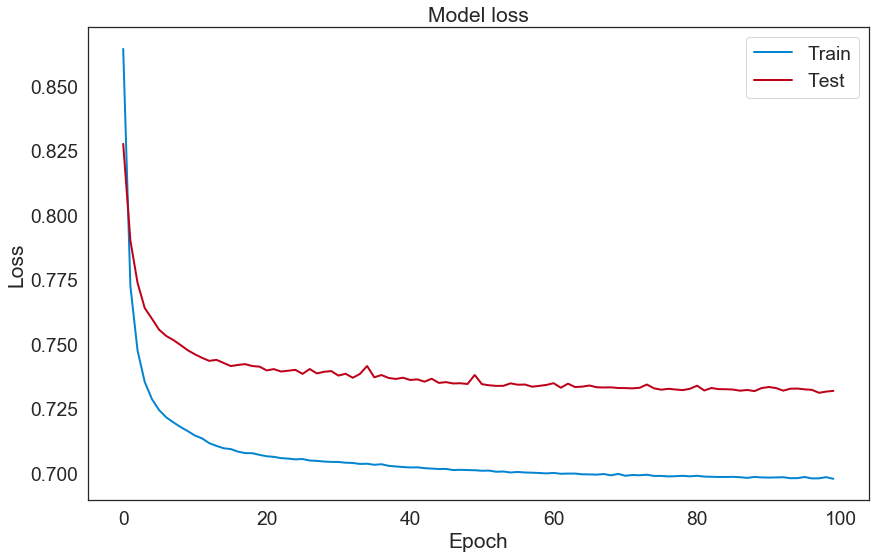

In [27]:
#Model Evaluation
#Model Loss

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [28]:
#Reconstruction Error Check
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()


,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.730853,0.002019
std,3.130109,0.044887
min,0.044768,0.000000
25%,0.245078,0.000000
50%,0.384568,0.000000
75%,0.610423,0.000000
max,203.502598,1.000000


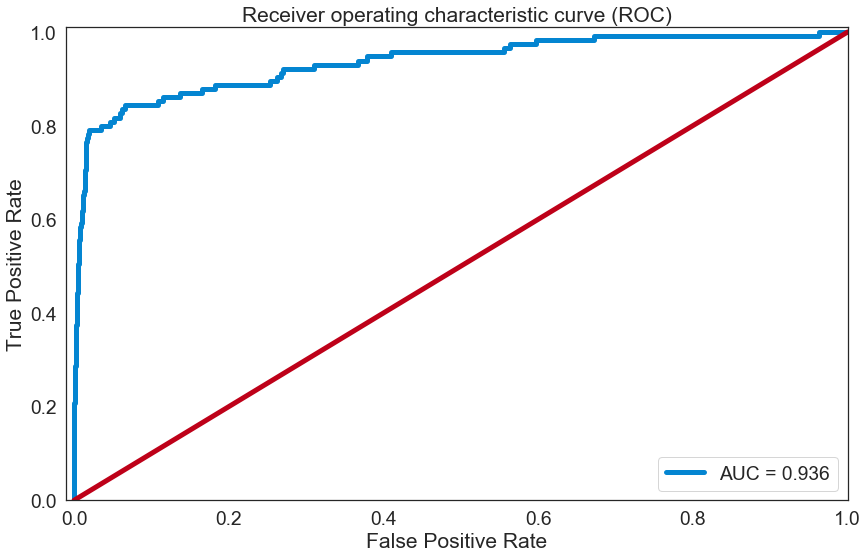

In [29]:
#ROC Curve Check
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

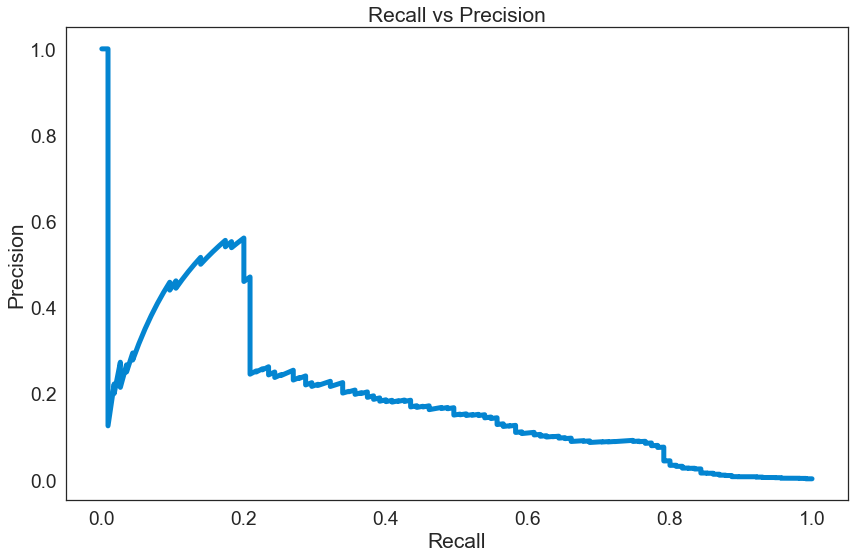

In [30]:
#Recall vs. Precision Thresholding
#Recall-v-Precision
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

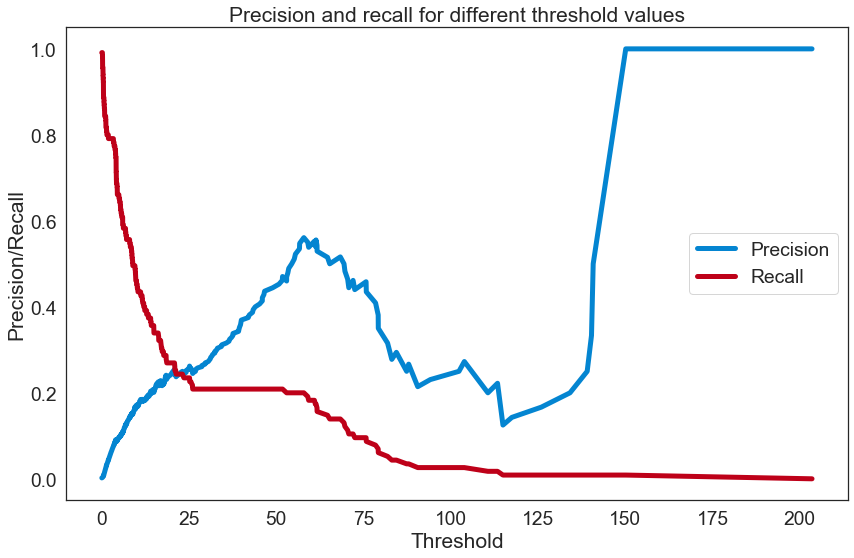

In [31]:
#precision-and-recall-tensorflow
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

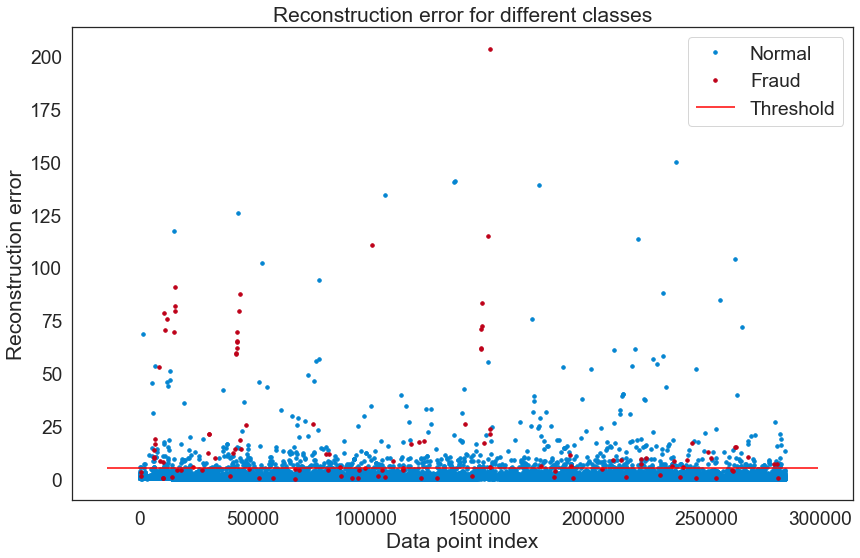

In [32]:
#Reconstruction Error vs Threshold Check
threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

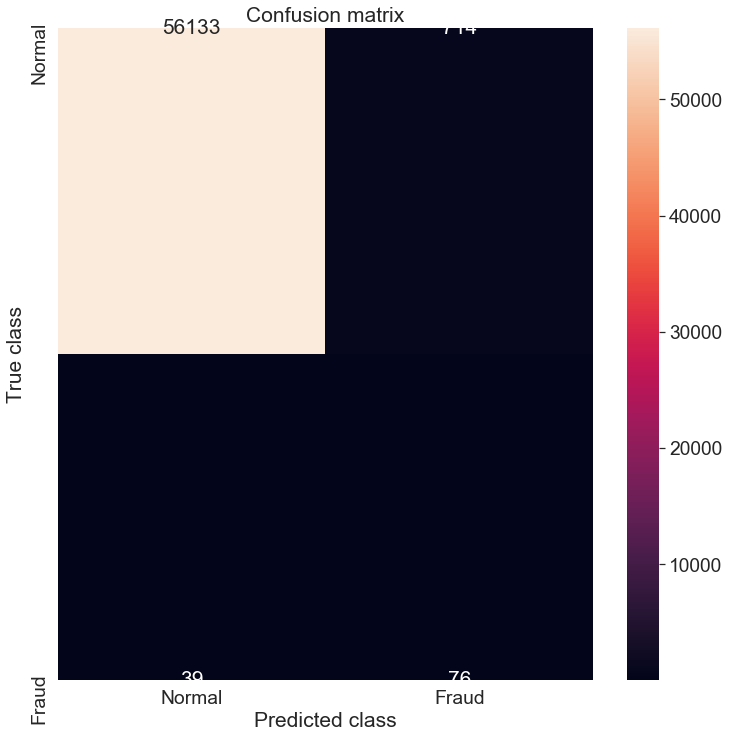

In [33]:
#Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()